In [1]:
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("upload_data").getOrCreate()


df = spark.read.csv("/ProjectTweets.csv", header=True, inferSchema=True)



In [2]:

df.show()

+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  0|1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|  1|1467810672|        Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|                                                                                               is upset that he ...|
|  2|1467810917|        Mon Apr 06 22:19:...|NO_QUERY|       mattycus|                                                                                               @Kenichan I dived...|
|  3|1467811184|        Mon Apr 06 22:19:...|NO_QUERY|        Ell

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit

# Spark session start
spark = SparkSession.builder.appName("AddHeaderToDataFrame").getOrCreate()

columns = ["number", "id", "date", "query", "username", "text"]



# Header row
header = ("number", "id", "date", "query", "username", "text")

# Adding header row
df = df.toDF(*header)


df.show()

+------+----------+--------------------+--------+---------------+--------------------+
|number|        id|                date|   query|       username|                text|
+------+----------+--------------------+--------+---------------+--------------------+
|     1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|     5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|     6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|     7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|     8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nope t...|
|     9|1467812025|Mon Apr 06 22:20:...|NO_

In [4]:

df.printSchema()



root
 |-- number: integer (nullable = true)
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- query: string (nullable = true)
 |-- username: string (nullable = true)
 |-- text: string (nullable = true)



In [5]:
print(f"There are {df.count()} rows and  {len(df.columns)} columns in the dataset.")

There are 1599999 rows and  6 columns in the dataset.


In [7]:
# Missing values check

from pyspark.sql import functions as func

df.select([func.count(func.when(func.isnan(c),c)).alias(c) for c in df.columns]).toPandas().head()

,number,id,date,query,username,text
0,0,0,0,0,0,0


In [8]:
# Duplicates check

df = df.dropDuplicates()
print(f"Number of rows in the dataframe after dropping the duplicates: {df.count()}")

Number of rows in the dataframe after dropping the duplicates: 1599999


In [9]:
#  Column types

df.dtypes


[('number', 'int'),
 ('id', 'bigint'),
 ('date', 'string'),
 ('query', 'string'),
 ('username', 'string'),
 ('text', 'string')]

In [10]:
drop_cols= ("id","query","username")
df = df.drop(*drop_cols)

In [11]:
df.printSchema()


root
 |-- number: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)



In [13]:
df.show(5, truncate = False)

+------+----------------------------+---------------------------------------------------------------------------------------------------------------------------------------------+
|number|date                        |text                                                                                                                                         |
+------+----------------------------+---------------------------------------------------------------------------------------------------------------------------------------------+
|179   |Mon Apr 06 22:31:57 PDT 2009|Staying at a friends house...house sitting, neighbors are SO loud-having a party                                                             |
|668   |Mon Apr 06 23:06:23 PDT 2009|i dont want to believe what im reading...buu,so sad                                                                                          |
|747   |Mon Apr 06 23:11:06 PDT 2009|Have an invite for &quot;Healthy Dining&quot; session at Ashok 

In [14]:
print(f"There are {df.count()} rows and  {len(df.columns)} columns in the dataset.")

There are 1599999 rows and  3 columns in the dataset.


In [20]:
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
import re

In [21]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [25]:
from pyspark.sql.types import StringType,FloatType

%time
clean_text = func.udf(lambda x: preprocess(x), StringType())
df = df.withColumn('text_cleaned',clean_text(func.col("text")))

CPU times: user 0 ns, sys: 1 µs, total: 1 µs
Wall time: 2.62 µs


In [26]:
df.show()


+------+--------------------+--------------------+--------------------+
|number|                date|                text|        text_cleaned|
+------+--------------------+--------------------+--------------------+
|   179|Mon Apr 06 22:31:...|Staying at a frie...|staying friends h...|
|   668|Mon Apr 06 23:06:...|i dont want to be...|dont want believe...|
|   747|Mon Apr 06 23:11:...|Have an invite fo...|invite quot healt...|
|  1175|Mon Apr 06 23:42:...|@amyserrata he wr...|wrote album ironi...|
|  1251|Mon Apr 06 23:47:...|@aniita_0517 Yes ...|yes sad topic hah...|
|  1289|Mon Apr 06 23:50:...|@heatherlibby  Oh...|oh well seems lik...|
|  1438|Tue Apr 07 00:01:...|Oh, and it's offi...|oh officially bir...|
|  1919|Tue Apr 07 00:36:...|my facebook is Fu...|     facebook fucked|
|  2582|Tue Apr 07 01:28:...|          need hugs |           need hugs|
|  2613|Tue Apr 07 01:31:...|is supposed to wo...|supposed work uni...|
|  2800|Tue Apr 07 01:46:...|@ThomasGudgeon We...|well yes shame

In [27]:
df = df.drop("text")


In [29]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud



In [43]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

window_spec = Window.orderBy("date")

df = df.withColumn("row_number", F.row_number().over(window_spec))

df.show()


2023-10-31 00:22:52,216 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2023-10-31 00:22:52,218 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2023-10-31 00:23:02,753 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2023-10-31 00:23:02,754 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------+--------------------+--------------------+----------+
|number|                date|        text_cleaned|row_number|
+------+--------------------+--------------------+----------+
|  8575|Fri Apr 17 20:30:...|working songg aun...|         1|
|  8576|Fri Apr 17 20:30:...|    sleep 4 30am 8am|         2|
|  8577|Fri Apr 17 20:30:...|wishing could coa...|         3|
|  8578|Fri Apr 17 20:30:...|well lilwo tough ...|         4|
|  8579|Fri Apr 17 20:30:...|taking much neede...|         5|
|  8580|Fri Apr 17 20:30:...|aww r cutest thin...|         6|
|  8581|Fri Apr 17 20:30:...|sweet josh work t...|         7|
|  8582|Fri Apr 17 20:30:...|boyfriend going t...|         8|
|  8585|Fri Apr 17 20:30:...|sorry loss honey ...|         9|
|  8584|Fri Apr 17 20:30:...|losing followers lol|        10|
|  8586|Fri Apr 17 20:30:...|               tired|        11|
|  8588|Fri Apr 17 20:30:...|misses updating c...|        12|
|  8583|Fri Apr 17 20:30:...|sim see tonight e...|        13|
|  8587|

In [47]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, FloatType
from textblob import TextBlob


#  UDF (User-Defined Function) 
schema = StructType([StructField("polarity", FloatType(), True), StructField("subjectivity", FloatType(), True)])

def calc_sentiment_udf(txt):
    blob = TextBlob(txt)
    return (blob.sentiment.polarity, blob.sentiment.subjectivity)

sentiment_udf = udf(calc_sentiment_udf, schema)

df = df.withColumn("sentiment", sentiment_udf(df["text_cleaned"]))

df = df.withColumn("polarity", df["sentiment.polarity"])
df = df.withColumn("subjectivity", df["sentiment.subjectivity"])

df.sample(withReplacement=False, fraction=0.1).show()


2023-10-31 00:29:28,116 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2023-10-31 00:29:28,118 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2023-10-31 00:29:37,105 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2023-10-31 00:29:50,957 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------+--------------------+--------------------+----------+--------------------+-----------+------------+
|number|                date|        text_cleaned|row_number|           sentiment|   polarity|subjectivity|
+------+--------------------+--------------------+----------+--------------------+-----------+------------+
|  8597|Fri Apr 17 20:31:...|haha player ladie...|        22|          {0.2, 0.3}|        0.2|         0.3|
|  8604|Fri Apr 17 20:31:...|see really cool a...|        30|    {-0.0125, 0.575}|    -0.0125|       0.575|
|  8614|Fri Apr 17 20:31:...|wanting work weekend|        40|          {0.0, 0.0}|        0.0|         0.0|
|  8620|Fri Apr 17 20:31:...|unfortunately thi...|        46| {-0.18333334, 0.55}|-0.18333334|        0.55|
|  8622|Fri Apr 17 20:31:...|totally missed re...|        47|       {0.35, 0.675}|       0.35|       0.675|
|  8625|Fri Apr 17 20:31:...|friends talking w...|        50|         {-0.3, 0.3}|       -0.3|         0.3|
|  8632|Fri Apr 17 20:32:...

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

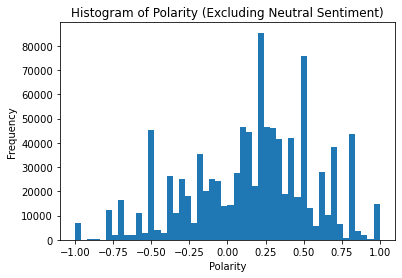

In [50]:
processed_data = df.filter(df["polarity"] != 0.0).select("polarity").toPandas()

plt.hist(processed_data["polarity"], bins=50)
plt.xlabel("Polarity")
plt.ylabel("Frequency")
plt.title("Histogram of Polarity (Excluding Neutral Sentiment)")
plt.show()